In [114]:
import sys
sys.path.append('..')

In [2]:
from curry.loader import Loader
from curry.structure import *
from tqdm import tqdm
import os
from bs4 import BeautifulSoup
import pandas as pd
from IPython.core.display import display, HTML

In [3]:
loader = Loader()

In [4]:
leifi = loader.simple()

In [80]:
leifi.shape

(11667, 7)

In [5]:
contents_by_url = leifi.groupby('grundwissen_url').content.first()

In [6]:
results = pd.DataFrame(
    [get_contents(c) for c in tqdm(contents_by_url)],
    index=contents_by_url.index)

100%|███████████████████████████████| 539/539 [00:30<00:00, 17.58it/s]


In [6]:
results_detailed = pd.DataFrame(
    [get_contents_detailed(BeautifulSoup(c).select_one('.content-thema')) for c in tqdm(contents_by_url)],
    index=contents_by_url.index)

100%|███████████████████████████████| 539/539 [00:17<00:00, 30.58it/s]


Text(0.5, 1.0, 'heading counts')

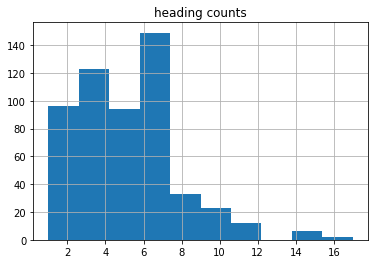

In [14]:
ax = results_detailed.paras_with_heading.apply(len).hist()
ax.set_title('heading counts')

Index([], dtype='object', name='grundwissen_url')


Text(0.5, 1.0, 'para_counts / document')

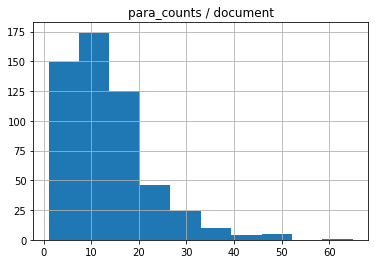

In [15]:
n_paras = results_detailed.paras_with_heading.apply(lambda x: len([p for ps in x.values() for p in ps]))
print(n_paras[n_paras==0].index)
ax = n_paras.hist()
ax.set_title('para_counts / document')

In [9]:
results_detailed = results_detailed[n_paras > 0]

<AxesSubplot:>

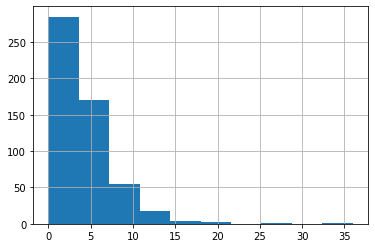

In [16]:
n_figures = results_detailed.figures.apply(lambda x: len([p for ps in x.values() for p in ps]))
n_figures.hist()

In [30]:

def get_all_paras(detailed_content_df):
    def expand(dikt):
        return pd.DataFrame([(heading, para) for heading in dikt for para in dikt[heading]]
                                , columns = ['heading', 'para'])

    to_concatenate = []
    for url, row in detailed_content_df.iterrows():
        df = expand(row['paras_with_heading'])
        df['url'] = url
        to_concatenate.append(df)

    paras = pd.concat(to_concatenate, axis=0)
    return paras

In [32]:
paras = get_all_paras(results_detailed)

In [33]:
paras.shape

(7217, 3)

<AxesSubplot:>

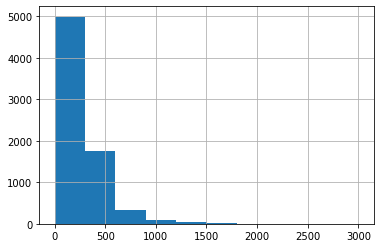

In [34]:
paras.para.apply(len).hist()

1    797
2    603
3    337
Name: para, dtype: int64

<AxesSubplot:>

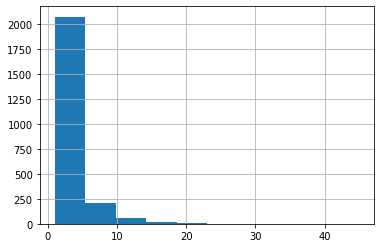

In [42]:
paras_per_heading = paras.groupby(['url', 'heading']).para.count()
display(
paras_per_heading.value_counts().sort_values(ascending=False).iloc[:3])

paras_per_heading.hist()

In [55]:
interval = paras.shape[0] // 1000 + 1
[(i, i+8) for i in range(0, paras.shape[0] - 1, interval)]

(8, 16)

In [56]:
import pickle
with open('../data/cache/babelfied.cache', 'rb') as f:
    bab_cache = pickle.load(f)

In [116]:
heading_entities = dict()

for url, rs in results_detailed.iterrows():
    annotations = bab_cache[url]
    heading_entities[url] = []
    for h in rs['paras_with_heading']:
        if h != NO_HEADING:
            for a in annotations:
                if a['text'] in h:
                    heading_entities[url].append(a)

In [118]:
(pd.Series([len(a) for a in heading_entities.values()]) == 0).sum()

55

In [99]:
def get_annotated_counts():
    for url, results in results_detailed.iterrows():
        paras_w_heading = results['paras_with_heading']
        figures = results['figures']
        annotations = bab_cache[url]
        heading_w_annotation_count = 0
        figure_w_annotation_count = 0
        para_w_annotation_count = 0
        total_heading_count = 0
        total_para_count = 0
        total_figure_count =0 
        for heading in paras_w_heading:
            if heading != NO_HEADING:
                heading_annotations = [a for a in annotations if a['text'] in heading]
            for para in paras_w_heading[heading]:
                para_w_annotation_count += any([a in para for a in annotations])
        for heading in figures:
            for _, figure_caption in figures[heading]:
                figure_w_annotation_count += any([(a in figure_caption) if figure_caption else False for a in annotations])
                total_figure_count += 1
        yield (url, heading_w_annotation_count, para_w_annotation_count, 
               total_heading_count, total_para_count, figure_w_annotation_count,
              total_figure_count)  
        
annotated_counts = pd.DataFrame(list(get_annotated_counts()), columns = [
    'url', 'ann_heading', 'ann_para', 
               'tot_heading', 'tot_para', 'ann_fig', 'tot_fig'
]).set_index('url')

In [106]:
annotated_counts[(annotated_counts.ann_para==0)]

,ann_heading,ann_para,tot_heading,tot_para,ann_fig,tot_fig
url,,,,,,
/astronomie/planetensystem/grundwissen/entfernungsbestimmung-planetensystemen,1,0,1,4,0,0
/mechanik/gleichfoermige-bewegung/grundwissen/umrechnen-von-geschwindigkeitseinheiten,2,0,2,9,0,1
/optik/elektromagnetisches-spektrum/grundwissen/elektromagnetisches-spektrum,0,0,0,1,2,2


In [75]:
out = []
for url, results in results_detailed.iterrows():
    n_found_in_heading = 0
    n_found_in_para = 0
    n_not_found = 0
    for ann_text in [a['text'] for a in bab_cache[url]]:
        found_in_heading = False
        found_in_para = False
        for heading in results['paras_with_heading']:
            if ann_text in heading:
                found_in_heading = True
                break
            elif ann_text in ' '.join(results['paras_with_heading'][heading]):
                found_in_para = True
                break
        if found_in_heading:
            n_found_in_heading += 1
        elif found_in_para:
            n_found_in_para += 1
        else:
            n_not_found += 1
    out.append((url, n_found_in_heading, n_found_in_para, n_not_found))
    
out = pd.DataFrame(out, columns = ['url', 'n_found_heading', 'n_found_para', 'n_not_found'])
        

<AxesSubplot:>

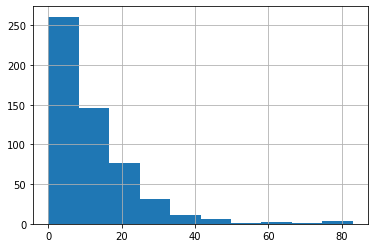

In [78]:
out.n_found_heading.hist()

<AxesSubplot:>

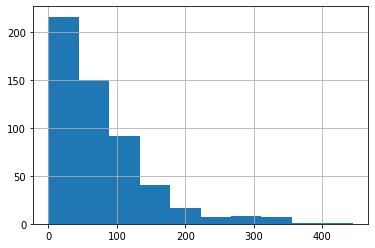

In [79]:
out.n_found_para.hist()

In [ ]:
for _, row in paras.iterrows():
    url = row['url']
    for ann in bab_cache[url]:
        if ann['text'] in 

In [7]:
def only_one_kind_of_heading(row):
    return sum([len(row[f'content_h{i}s'] or []) > 0 for i in range(2, 6)]) == 1


results[results.apply(only_one_kind_of_heading, axis=1)].shape[0] / results.shape[0]

0.45083487940630795

In [18]:
is_na_count = results.notna().sum(axis=0)
total_count = results.shape[0]
pd.DataFrame(
    {'count': is_na_count, 
     'pct': (is_na_count / total_count * 100).round(2)})

,count,pct
topic_name,539,100.00
lesson_name,539,100.00
content_thema,539,100.00
das_wichtigste_points,491,91.09
image_and_text,10,1.86
remaining_tables,120,22.26
images,122,22.63
figures,340,63.08
tasks_box,114,21.15
animations,305,56.59


In [8]:
import numpy as np

In [9]:
out = np.zeros((5,5))
for i in [2,3,4,5,6]:
    for j in [2,3,4,5,6]:
        out[i-2, j-2] = results[results[f'content_h{i}s'].notna() & 
                results[f'content_h{j}s'].notna()].shape[0]

In [11]:
out

array([[  2.,   2.,   0.,   0.,   0.],
       [  2.,  33.,  16.,  11.,   9.],
       [  0.,  16., 433., 232.,  15.],
       [  0.,  11., 232., 273.,  16.],
       [  0.,   9.,  15.,  16.,  22.]])

[<div class="rs_skip rsbtn rs_preserve" id="readspeaker_button1"><a accesskey="L" class="rsbtn_play" href="//app-eu.readspeaker.com/cgi-bin/rsent?customerid=12617&amp;lang=de_de&amp;readclass=content-thema&amp;dict=customer,math&amp;disable=translation&amp;rule=math&amp;xslrule=math&amp;url="><span class="rsbtn_left rsimg rspart"><span class="rsbtn_text"><span>Vorlesen</span></span></span> </a></div>,
 <a accesskey="L" class="rsbtn_play" href="//app-eu.readspeaker.com/cgi-bin/rsent?customerid=12617&amp;lang=de_de&amp;readclass=content-thema&amp;dict=customer,math&amp;disable=translation&amp;rule=math&amp;xslrule=math&amp;url="><span class="rsbtn_left rsimg rspart"><span class="rsbtn_text"><span>Vorlesen</span></span></span> </a>,
 <span class="rsbtn_left rsimg rspart"><span class="rsbtn_text"><span>Vorlesen</span></span></span>,
 <span class="rsbtn_text"><span>Vorlesen</span></span>,
 <span>Vorlesen</span>,
 <div class="rich-text-main"> <div class="tex2jax_process"><div style="clear:bo
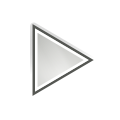
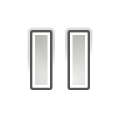
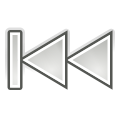
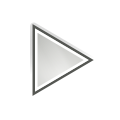
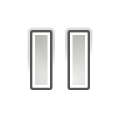
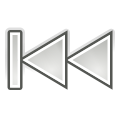
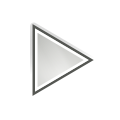
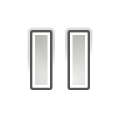
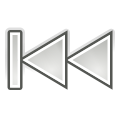
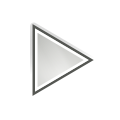
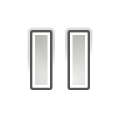
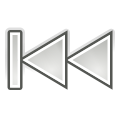
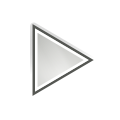
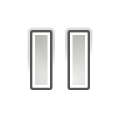
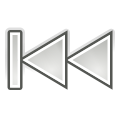
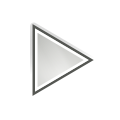
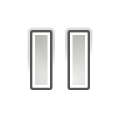
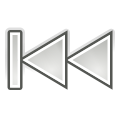
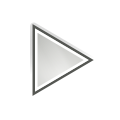
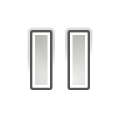
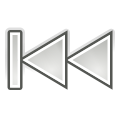
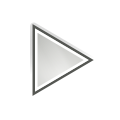
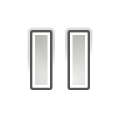
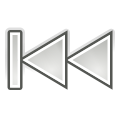
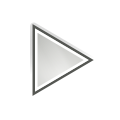
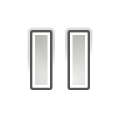
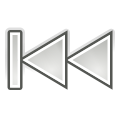
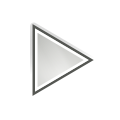
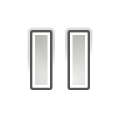
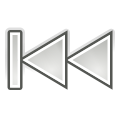

In [22]:
get_heading_structure_and_contents_by_heading(
    BeautifulSoup(pcontents_by_url.iloc[0]).select_one('.content-thema'))